In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import mysql.connector
import seaborn as sns
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.contingency_tables import Table
from scipy.stats import chi2_contingency

In [2]:
%matplotlib inline

### Functions to query SQL from python

In [3]:
#function to run simple SQL query from python
def create_table_from_SQL(user, database, password, query):
    '''
    - A function that returns a pandas dataframe from a SQL query in python
    ---------------
    - user: user for your local SQL connection in string format
    - database: schema name where your database is stored in string format
    - password: password to access your local SQL connection in string format
    - query: SQL query in string format; enclose with double quotes and use single quotes
    to designate VARCHAR values within queries; use schema_name.table_name after FROM statement
    '''
    cnx = mysql.connector.connect(user=user, database=database, password=password)
    cursor = cnx.cursor()
    query = query
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall())
    df.columns = cursor.column_names
    return df

### Initial Data Analysis

#### *Most frequent defects among NICU admitted patients (2018 only)*

In [4]:
query = "SELECT CA_ANEN, CA_MNSB, CA_CCHD, CA_CDH, CA_OMPH,\
        CA_GAST, CA_LIMB, CA_CLEFT, CA_DOWN, CA_DISOR, CA_HYPO, AB_SEIZ\
        FROM cdc_2018_full\
        WHERE AB_NICU = 'Y'"

In [5]:
#pull in table with all abnormalities for patients admitted to the NICU
nicu_defect = create_table_from_SQL('root','cdc_project','******', query)

Text(0.5, 1.0, 'Total Number of Patients Admitted to the NICU')

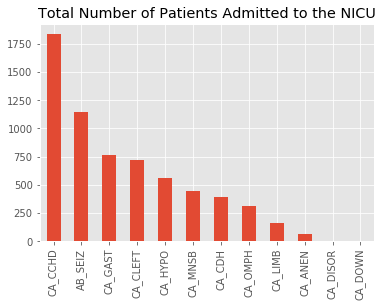

In [30]:
#plot total number of patients admitted to the NICU for each reported abnormality
#correct to detect 'X' for down and cleft
nicu_defect.apply(lambda x: sum(x == 'Y'), axis=0).sort_values(ascending=False).plot.bar()
plt.title('Total Number of Patients Admitted to the NICU')

#### *Proportion of patients with each defect admitted to NICU vs proportion of non-defect patients admitted - visual results and statistical analysis (2018 only)*

In [31]:
query = "SELECT CA_ANEN, CA_MNSB, CA_CCHD, CA_CDH, CA_OMPH,\
        CA_GAST, CA_LIMB, CA_CLEFT, CA_DOWN, CA_DISOR, CA_HYPO, AB_SEIZ, AB_NICU\
        FROM cdc_2018_full"

In [32]:
#pull in table with all observations for abnormalities and NICU admission
defect_nicu_props = create_table_from_SQL('root','cdc_project','******', query)

In [33]:
#find overall rate at which patients are admitted to the NICU
overall_prop=len(defect_nicu_props.AB_NICU[defect_nicu_props.AB_NICU=='Y'])/len(defect_nicu_props.AB_NICU)

In [34]:
#create dataframe with admitted proportion per abnormality
admits = pd.DataFrame(defect_nicu_props[defect_nicu_props.AB_NICU=='Y'].apply(lambda x: sum(x=='Y'), axis=0))
total = defect_nicu_props.apply(lambda x: sum(x=='Y'), axis=0)
admits = pd.concat([admits,total], axis=1)
admits.columns = ['Admits', 'Total']
admits['props'] = admits['Admits']/admits['Total']
admits = admits.iloc[0:-1,:]
admits = admits.fillna(value=0)
admits.sort_values(by='props', ascending = False, inplace = True)

Text(0.5, 1.0, 'Proportion of Patients with Defect Admitted to the NICU')

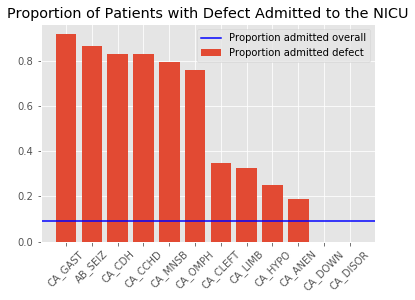

In [37]:
#plot the dataframe
plt.bar(x=admits.index, height = admits.props)
plt.xticks(rotation=45)
plt.axhline(y=overall_prop, color='blue', label='overall NICU admit')
plt.legend(("Proportion admitted overall", "Proportion admitted defect"))
plt.title('Proportion of Patients with Defect Admitted to the NICU')

Text(0.5, 1.0, 'Proportion and Total Admits Two by Two')

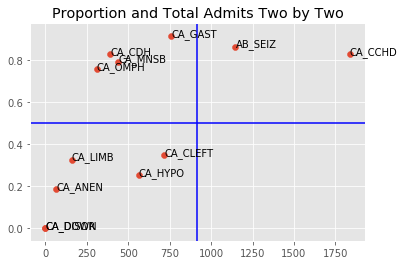

In [38]:
#create 2x2 plot showing proportion and total cases
#plot indicates that analysis should be focused on CA_CCHD as highest urgency abnormality
#literature review confirms unmet need and mostly unknown etiology
plt.scatter(x=admits.Admits, y=admits.props)
for i, txt in enumerate(admits.index):
    plt.annotate(txt, (admits.Admits[i], admits.props[i]))
plt.axhline(y=0.5, color='blue')
plt.axvline(x=admits['Admits']['CA_CCHD']/2, color='blue')
plt.title('Proportion and Total Admits Two by Two')

### In-Depth Analysis for CCHD

In [4]:
#modified version of Bettina's function which creates downsampled dataset for specific defects
#vs overall NICU admissions

def downsample_df (df, variable):

    '''
    Remove undefined information on defect presence admissions (defect == 'U'),
    create a binary target vector, and create a "balanced" dataframe
    with all defect cases and matching numbers of randomly selected non-defect cases.
    --------------------
    df: full dataframe
    variable: variable or defect of interest in string format
    '''

    # remove unknown class from df
    df_no_unknown = df[df[variable].isin(['Y', 'N'])]

    # Create binary target vector, NICU = yes classified as class 0
    df_y_n = pd.DataFrame(np.where((df_no_unknown[variable] == 'Y'), 0, 1))

    # Get indicies of each class' observations
    index_class0 = np.where(df_y_n == 0)[0]
    index_class1 = np.where(df_y_n == 1)[0]

    # Get numbers of observations in class 0
    n_class0 = len(index_class0)

    # Randomly sample the same number of observations from class 1 as in class 0, without replacement
    np.random.seed(0)
    index_class1_downsampled = np.random.choice(index_class1, size=n_class0, replace=False)

    # Create dataframes for NICU and downsampled non-NICU
    df_defect = df_no_unknown.iloc[index_class0]
    df_adj_NONdefect = df_no_unknown.iloc[index_class1_downsampled]

    # Append into 1 dataframe
    df_downsampled = df_defect.append(df_adj_NONdefect)

    return df_downsampled

#### *Create Dataframe - using continuous, not binned where possible; *

In [6]:
# begin dictionary of columns to analyze for CCHD - includes pre-pregnancy and gestational features
# features re: delivery and labor are not useful for this use case
variables = {'nominal_categorical':['MBSTATE_REC','MRACEHISP','MAR_P','DMAR','MEDUC','FRACEHISP',\
                                    'FEDUC','WIC','RF_PDIAB','RF_GDIAB','RF_PHYPE','RF_GHYPE',\
                                    'RF_EHYPE','RF_PPTERM','RF_INFTR','RF_FEDRG','RF_ARTEC','RF_CESAR',\
                                  'IP_GON','IP_SYPH','IP_CHLAM','IP_HEPB','IP_HEPC', 'PAY', 'SEX'],\
           'ordinal_categorical':['PRECARE', 'DOB_MM'],\
           'continuous':['MAGER', 'FAGECOMB','PRIORTERM','PRIORLIVE','PRIORDEAD','LBO_REC','TBO_REC',\
                         'ILLB_R','ILP_R','PREVIS','CIG_0','CIG_1','CIG_2','CIG_3','M_Ht_In','BMI',\
                         'WTGAIN','RF_CESARN','COMBGEST'],\
            'target':['CA_CCHD']}

In [12]:
#create string of variables for SQL query
vrs = variables['nominal_categorical']+variables['ordinal_categorical']+variables['continuous']+variables['target']
",".join(vrs)

'MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,IP_SYPH,IP_CHLAM,IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,PRIORLIVE,PRIORDEAD,LBO_REC,TBO_REC,ILLB_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,M_Ht_In,BMI,WTGAIN,RF_CESARN,COMBGEST,CA_CCHD'

In [29]:
#pull selected variables from 2016-2018 databases in SQL and append to a single dataframe
query18 = "SELECT MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,\
                RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,\
                IP_SYPH,IP_CHLAM,IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,\
                PRIORLIVE,PRIORDEAD,LBO_REC,TBO_REC,ILLB_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,\
                M_Ht_In,BMI,WTGAIN,RF_CESARN,COMBGEST,CA_CCHD\
         FROM cdc_project.cdc_2018_full"

query17 = "SELECT MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,\
                RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,\
                IP_SYPH,IP_CHLAM,IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,\
                PRIORLIVE,PRIORDEAD,LBO_REC,TBO_REC,ILLB_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,\
                M_Ht_In,BMI,WTGAIN,RF_CESARN,COMBGEST,CA_CCHD\
         FROM cdc_project.cdc_2017_full"

query16 = "SELECT MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,\
                RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,\
                IP_SYPH,IP_CHLAM,IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,\
                PRIORLIVE,PRIORDEAD,LBO_REC,TBO_REC,ILLB_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,\
                M_Ht_In,BMI,WTGAIN,RF_CESARN,COMBGEST,CA_CCHD\
         FROM cdc_project.cdc_2016_full"

queries = [query18, query17, query16]
            
cchd = pd.DataFrame()

for query in queries:
    temp = create_table_from_SQL('root','cdc_project','******', query)
    temp = downsample_df(temp, 'CA_CCHD')
    cchd = cchd.append(temp)   

In [32]:
#convert continuous variables to float
#update to split out ordinal categorical separately
for x in variables['continuous']:
    cchd[x]=cchd[x].astype('float')

In [33]:
#convert nominal categorical variables to category
for x in variables['nominal_categorical']:
    cchd[x]=cchd[x].astype('category')

In [34]:
#convert target variable to binary
cchd.CA_CCHD=np.where(cchd.CA_CCHD=='Y',1,0)

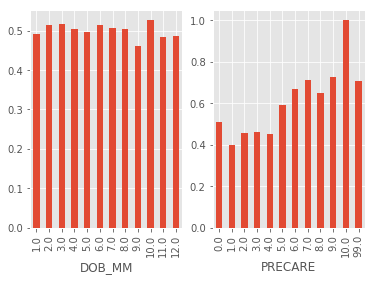

In [48]:
#view ordinal categorical variables by plotting proportion of CCHD in each category
#based on the plots - DOB_MM should be categorical and PRECARE should be continuous
plt.subplot(1,2,1)
cchd.groupby('DOB_MM')['CA_CCHD'].mean().plot.bar()
plt.subplot(1,2,2)
cchd.groupby('PRECARE')['CA_CCHD'].mean().plot.bar()

In [49]:
#convert ordinal categorical variables
cchd.DOB_MM = cchd.DOB_MM.astype('category')
cchd.PRECARE = cchd.PRECARE.astype('float')

#### *Missingness, Imputation, and Correlation Investigation for Continuous Variables*

In [ ]:
#create missingness types:


In [ ]:
#impute median into for continuous vars with 99s that represent unknown
#need more logical strategy for dealing with missingness and imputation long-term
#clean up code to use .loc to avoid assigning to a copy of a slice
for x in ['PRIORTERM','PRIORDEAD','PRIORLIVE','PRECARE', 'PREVIS', 'CIG_0', 'CIG_1',\
         'CIG_2', 'CIG_3', 'FAGECOMB']:
    cchd18[x][cchd18[x]==99] = cchd18[x].median()

In [50]:
def continuous_eda(df, var_list, target_var):
    '''
    - A function that analyzes the relationship of a continuous variable to an abnormality target variable
    - Returns overlapping histograms for Y/N target variable groups and a bar graph with means for
    Y/N groups side-by-side. Two-way t-test results are returned underneath the graph.
    ---------------
    - df: the dataframe containing variables of interest
    - var_list: a list of continuous variables as strings
    - target_var: the target abnormality
    '''
    for x in var_list:
        a = df[df[target_var]==1][x]
        b = df[df[target_var]==0][x]
        plt.figure()
        plt.subplot(1,2,1)
        plt.hist(a, color='red',alpha=0.3)
        plt.hist(b, color='blue', alpha=0.3)
        plt.figtext(0,0,stats.ttest_ind(a,b))
        plt.title('dist '+x)
        plt.subplot(1,2,2)
        plt.bar('Y', np.mean(a), alpha=0.3)
        plt.bar('N', np.mean(b), alpha=0.3)
        plt.title('mean '+x)

In [ ]:
#matching the literature, pre-pregnancy cigarette intake looks significant, among other factors
#potential to combine priorterm, priorlive, priordead?
continuous_eda(cchd18, variables['continuous'], 'CA_CCHD')

In [ ]:
#pairwise collinearity investigation
sns.pairplot(cchd18[variables['continuous']])

In [ ]:
#vif investigation

 - **missingness, imputation, and independence investigation for nominal categorical variables**

In [ ]:
#view missingness in nominal_categorical - '9' or 'U'
for x in variables['nominal_categorical']:
    print(cchd18[x].value_counts())

In [ ]:
#assign 'U' to majority class
#fix to assign by random sample
for x in variables['nominal_categorical']:
    major_cat = cchd18[x].value_counts().sort_values(ascending=False).index[0]
    cchd18[x][cchd18[x]=='U']= major_cat 

In [ ]:
#assign 'X' to 'N'
for x in variables['nominal_categorical']:
    cchd18[x].replace('X','N', inplace=True)

In [ ]:
def categorical_eda(df, var_list, target_var):
    '''
    - A function that analyzes the relationship of a categorical variable to an abnormality target variable
    - Returns mosaic plot with chi-square test results underneath
    ---------------
    - df: the dataframe containing variables of interest
    - var_list: a list of categorical variables as strings
    - target_var: the target abnormality
    '''
    for x in var_list:
        m = pd.crosstab(cchd18[x], cchd18[target_var])
        plt.figure()
        mosaic(m.stack(), gap=0.05)
        plt.title('mosaic'+x)
        plt.figtext(0,0,stats.chi2_contingency(m)[0:2])

In [ ]:
categorical_eda(cchd18, variables['nominal_categorical'], 'CA_CCHD')